In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import os
from pathlib import Path
from plaid.evaluation import batch_rmsd_calculation, run_tmalign, RITAPerplexity, batch_rmspd_from_pdb_paths
from plaid.utils import extract_avg_b_factor_per_residue, read_sequences_from_fasta
import numpy as np
import matplotlib.pyplot as plt

# sample_dir = Path("/data/lux70/plaid/artifacts/samples/5j007z42/by_length/")
sample_dir = Path("/data/lux70/plaid/artifacts/samples/by_length/")

# Structure

## PLAID

In [6]:
# lengths = [int(x) for x in os.listdir(sample_dir)]
lengths = np.arange(32, 174, 4)
lengths.sort()
print(lengths)

[ 32  36  40  44  48  52  56  60  64  68  72  76  80  84  88  92  96 100
 104 108 112 116 120 124 128 132 136 140 144 148 152 156 160 164 168 172]


In [7]:
all_stats = {}

import pandas as pd


for l in lengths:
    try:
        all_stats[l] = pd.read_csv(sample_dir / str(l) / "designability.csv")
    except Exception as e:
        print(e)
        pass

In [8]:
big_df = pd.concat(list(all_stats.values()))
print(big_df.shape)
big_df.head()

(2304, 18)


,Unnamed: 0,pdb_paths,sequences,inverse_generated_pdb_paths,phantom_generated_pdb_paths,plddt,ccrmsd,scrmsd,cctm,sctm,designable,perplexity,molecular_weight,aromaticity,instability_index,isoelectric_point,gravy,charge_at_pH
0,0,/data/lux70/plaid/artifacts/samples/by_length/...,QRMAGIWADLLGLRRVGVRDSFFELGGDSIMSLQLVERARGAGLPL...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,73.284277,0.091816,0.415932,0.99888,0.97777,True,6.093750,7122.2955,0.062500,47.112500,11.698965,0.021875,3.856169
1,1,/data/lux70/plaid/artifacts/samples/by_length/...,GKYQIGGVPDGAKGERLTPEALDYVGLLHRLFSSRRISLLSQREHK...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,50.418323,5.691837,12.336930,0.59505,0.41814,False,16.666278,7192.1143,0.062500,34.587500,9.226667,-0.610938,1.945932
2,2,/data/lux70/plaid/artifacts/samples/by_length/...,CVCDGHAERCFIRRLTRDANKAYPETWCIECSHGTMGDYCEKCMPH...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,67.839591,3.669174,8.208522,0.79190,0.53842,False,18.571555,7424.3129,0.125000,58.190781,5.436275,-0.657813,-3.044961
3,3,/data/lux70/plaid/artifacts/samples/by_length/...,DYYSLLNVPQSASKKEIKTAYRKLALKYHPDKNADNPNAEEKFKNL...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,84.917634,0.059241,0.784830,0.99953,0.93188,True,4.756112,7428.1131,0.109375,37.481250,8.843725,-1.345313,1.850928
4,4,/data/lux70/plaid/artifacts/samples/by_length/...,KKEGIYRHLSGSYARDAYGLYHGEQRIEAAKPISFTMVSMNLFRDQ...,/data/lux70/plaid/artifacts/samples/by_length/...,/data/lux70/plaid/artifacts/samples/by_length/...,44.938960,1.547409,11.950506,0.80107,0.34216,True,19.221742,7373.1784,0.109375,31.454688,8.264025,-0.853125,1.031109


Text(0.5, 1.0, 'scTM')

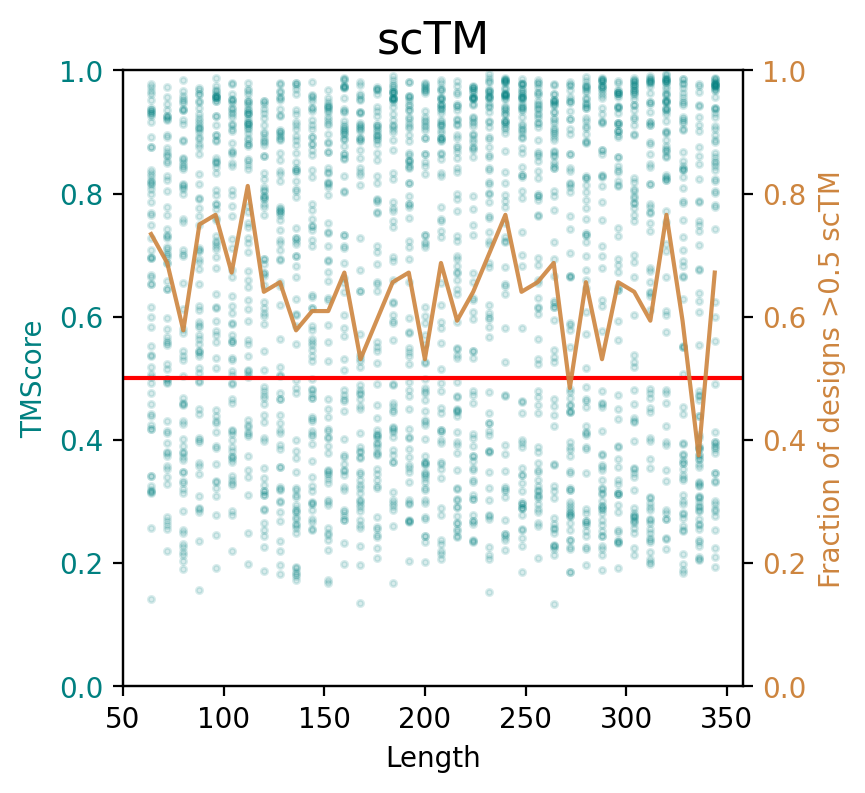

In [17]:
metric = "sctm"

fig,ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) > 0.5).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,1)
ax.axhline(0.5, c='red')
ax.set_ylabel("TMScore", c='teal')
ax.tick_params(axis='y', labelcolor='teal')
ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru", alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs >0.5 scTM", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')


plt.title("scTM", fontsize=16)

Text(0.5, 1.0, 'ccTM')

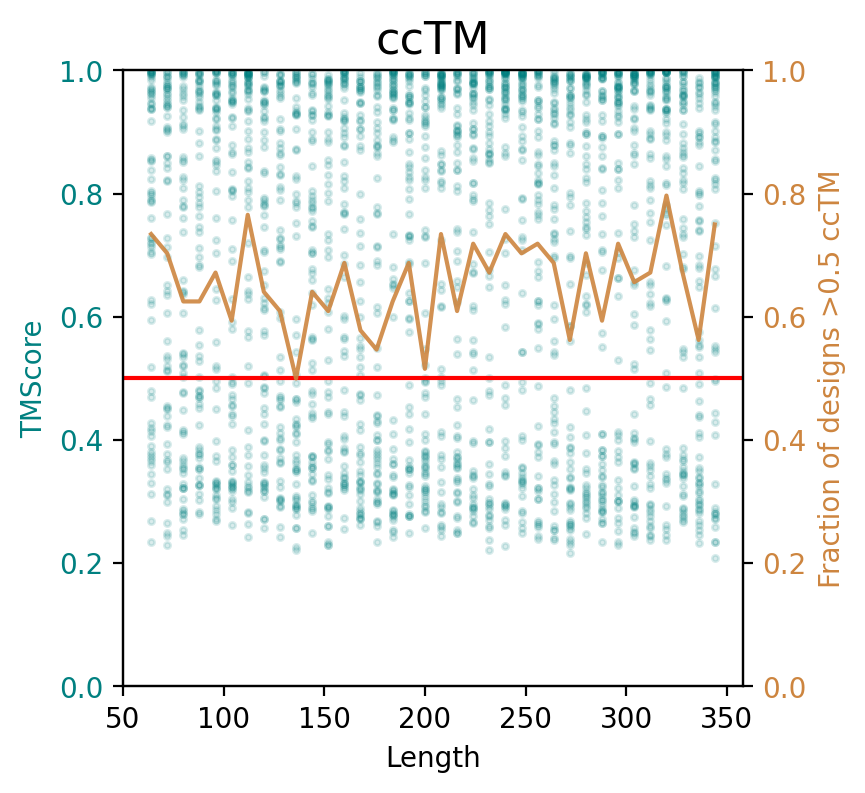

In [18]:
metric = "cctm"

fig,ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) > 0.5).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,1)
ax.axhline(0.5, c='red')
ax.set_ylabel("TMScore", c='teal')
ax.tick_params(axis='y', labelcolor='teal')
ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs >0.5 ccTM", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')


plt.title("ccTM", fontsize=16)

Text(0.5, 1.0, 'scRMSD')

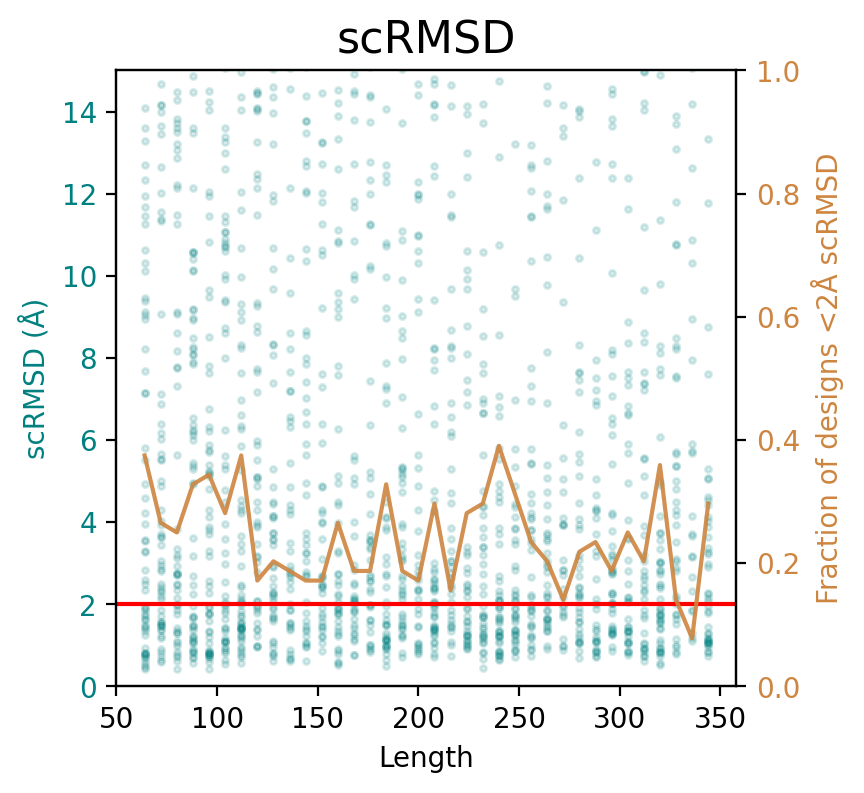

In [21]:
metric = "scrmsd"

fig,ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) < 2).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
    
ax.set_ylim(0,15)
ax.axhline(2, c='red')
ax.set_ylabel("scRMSD (Å)", c='teal')
ax.tick_params(axis='y', labelcolor='teal')

ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs <2Å scRMSD", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')

plt.title("scRMSD", fontsize=16)

Text(0.5, 1.0, 'ccRMSD')

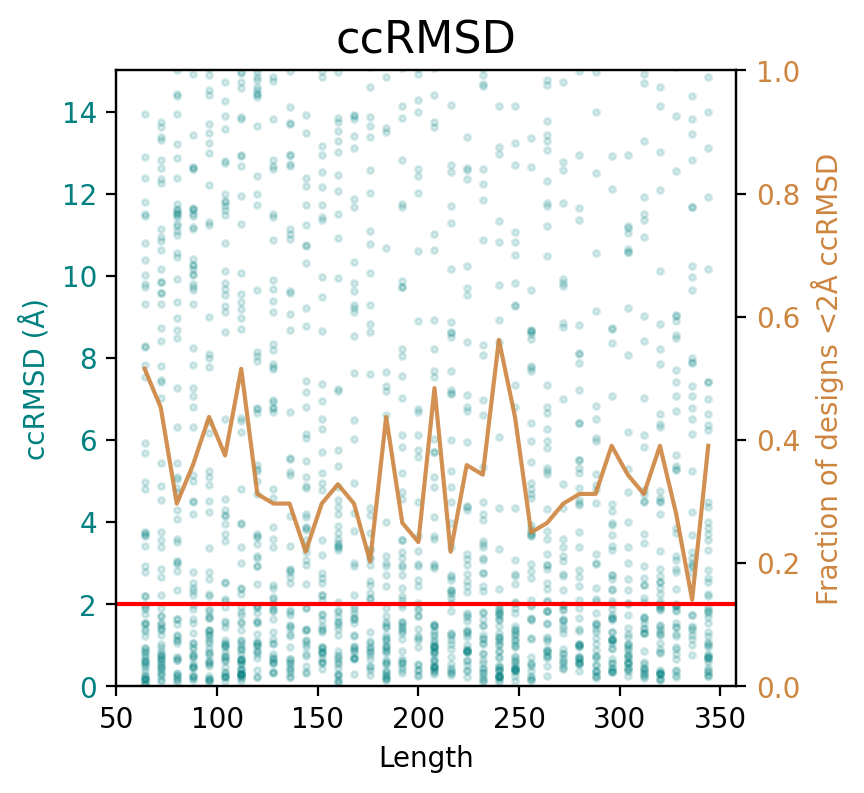

In [22]:
metric = "ccrmsd"

fig,ax = plt.subplots(1,1,figsize=(4,4), dpi=200)

designable = []

for k, v in all_stats.items():
    data = v[metric]
    designable.append((np.array(data) < 2).sum() / len(data))
    ax.scatter([int(k) * 2] * len(data), data, s=5, c="teal",alpha=0.15)
    
ax.set_ylim(0,15)
ax.axhline(2, c='red')
ax.set_ylabel("ccRMSD (Å)", c='teal')
ax.tick_params(axis='y', labelcolor='teal')

ax.set_xlabel("Length")

scale = np.array(lengths) * 2

ax_ = ax.twinx()
ax_.plot(scale, designable, c="peru",alpha=0.9)
ax_.set_ylim(0, 1)
ax_.set_ylabel("Fraction of designs <2Å ccRMSD", c='peru')
ax_.tick_params(axis='y', labelcolor='peru')

plt.title("ccRMSD", fontsize=16)

In [41]:
!ls /data/lux70/plaid/baselines/protpardelle/samples_large

maxlen100  maxlen300  maxlen400  maxlen500  samples
maxlen200  maxlen350  maxlen450  maxlen550  samples_inits


In [83]:
sampdir = Path("/data/lux70/plaid/baselines/protpardelle/samples_large")

for x in os.listdir(sampdir):
    pdbs = glob.glob(str(sampdir / x / "*pdb"))
    for p in pdbs:
        new_name = sample_dir / x / "generated/structure
        print(pdbs[0])

/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen500/len496_samp22.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen350/len312_samp13.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen400/len384_samp35.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen100/len072_samp17.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen300/len264_samp31.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen550/len512_samp1.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen450/len424_samp3.pdb
/data/lux70/plaid/baselines/protpardelle/samples_large/maxlen200/len112_samp40.pdb


In [72]:
import glob

pdbpaths = glob.glob(str(sampdir / "samples/generated/structures/*pdb"))

In [79]:
# for p in pdbpaths:
#     stem = Path(p).stem
#     length = int(stem.split("_")[0].lstrip("len"))

#     if (length < 550) and (length > 500):
#         os.rename(p, sampdir / "maxlen550" / f"{stem}.pdb")
#         # print(p, sampdir / "maxlen350" / f"{stem}.pdb")

In [28]:
sampdir = Path("/data/lux70/plaid/artifacts/samples/by_length")
for length in list(range(176, 257, 4)):
    print(len(os.listdir(sampdir / str(length) / "generated/structures" )))
    # shutil.rmtree

64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64
64


In [30]:
fasta = "/data/lux70/plaid/baselines/proteingenerator/by_length/inverse_generated/sequences.fasta"

from plaid.utils import read_sequences_from_fasta
sequences_dict = read_sequences_from_fasta(fasta)

In [31]:
len(sequences_dict)

3955

In [36]:
def get_len(x):
    return int(x.split("_")[0].lstrip("len"))

headers = []
sequences = []


for k, v in sequences_dict.items():
    length = get_len(k)
    if length >= 312:
        headers.append(k)
        sequences.append(v)
        

In [40]:
from plaid.utils import write_to_fasta


outpath = "/data/lux70/plaid/baselines/proteingenerator/by_length/inv_partial_tmp.fasta"

write_to_fasta(sequences, outpath, headers)

Wrote 1907 sequences to /data/lux70/plaid/baselines/proteingenerator/by_length/inv_partial_tmp.fasta.
